In [162]:
# Running this cell will provide you with a token to link your drive to this notebook
from google.colab import drive
drive.mount('/content/drive')

In [163]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('drive/My Drive/data_foot/DFU'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [164]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB3, ResNet50
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks

BATCH_SIZE = 32
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
NUM_CLASSES = 2


In [165]:
TRAIN_PATH ='drive/My Drive/data_foot/DFU/Patches'
TEST_PATH ='drive/My Drive/data_foot/DFU/TestSet'

(224, 224, 3)


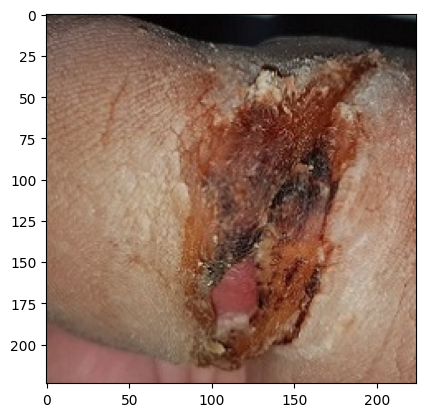

In [166]:
fpath='drive/My Drive/data_foot/DFU/Patches/Abnormal(Ulcer)/10.jpg'
img=plt.imread(fpath)
print (img.shape)
imshow(img)

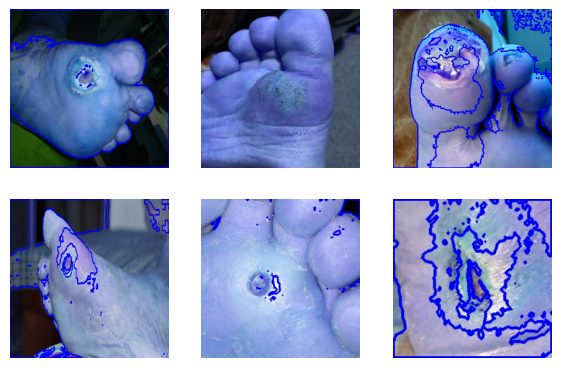

In [167]:
# Visualize the testing dataset
plt.figure(figsize = (7, 7))

i = 0
for images in test_ds.take(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images.numpy().astype("uint8"))
    plt.axis("off")
    i += 1

In [168]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

def process_image(image_path,save_path):
    # Read the image
    img = cv2.imread(image_path)

    # Convert the image to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define range for skin color in HSV space
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)

    # Threshold the image to get only skin regions
    skin_mask = cv2.inRange(hsv, lower_skin, upper_skin)

    # Invert skin mask to get non-skin regions
    non_skin_mask = cv2.bitwise_not(skin_mask)

    # Bitwise-AND non-skin mask with original image to get non-skin regions
    non_skin_region = cv2.bitwise_and(img, img, mask=non_skin_mask)

    # Convert non-skin region to grayscale
    gray_non_skin_region = cv2.cvtColor(non_skin_region, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image to get the significantly dark and red regions
    _, dark_regions = cv2.threshold(gray_non_skin_region, 0, 255, cv2.THRESH_BINARY)
    red_regions = cv2.inRange(non_skin_region, (0, 0, 100), (80, 80, 255))

    # Combine dark and red regions
    anomaly_regions = cv2.bitwise_or(dark_regions, red_regions)

    # Find contours of anomaly regions
    contours, hierarchy = cv2.findContours(anomaly_regions, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the original image to highlight anomaly regions
    cv2.drawContours(img, contours, -1, (0, 0, 255), 3)

    # Save the results
    save_original_with_anomalies_path = os.path.join(save_path, "Original_with_Anomalies_" + os.path.basename(image_path))
    cv2.imwrite(save_original_with_anomalies_path, cv2.cvtColor(img, cv2.COLOR_BGR2RGB))



# Define the directory where your images are stored
new_Abnormal = 'drive/My Drive/data_foot/DFU/Patches/Abnormal(Ulcer)'
new_Normal = 'drive/My Drive/data_foot/DFU/Patches/Normal(Healthy skin)'
new_test = 'drive/My Drive/data_foot/DFU/TestSet'


# Define the directory where you want to save the modified images
save_new_Abnormal = 'drive/My Drive/data_foot/DFU/Patches/new/new_Abnormal'
save_new_Normal = 'drive/My Drive/data_foot/DFU/Patches/new/new_Normal'
save_new_test = 'drive/My Drive/data_foot/DFU/new_TestSet'

if not os.path.exists(save_new_Abnormal):
    os.makedirs(save_new_Abnormal)
if not os.path.exists(save_new_Normal):
    os.makedirs(save_new_Normal)
if not os.path.exists(save_new_test):
    os.makedirs(save_new_test)

# Iterate through all files in the directory
for filename in os.listdir(new_Abnormal):
    if filename.endswith('.jpg'):  # Check if the file is an image (adjust the extension if needed)
        # Construct the full path to the image
        image_path = os.path.join(new_Abnormal, filename)

        # Call the process_image function for each image
        process_image(image_path, save_new_Abnormal)


# Iterate through all files in the directory
for filename in os.listdir(new_test):
    if filename.endswith('.jpg'):  # Check if the file is an image (adjust the extension if needed)
        # Construct the full path to the image
        image_path = os.path.join(new_test, filename)

        # Call the process_image function for each image
        process_image(image_path, save_new_test)

# Iterate through all files in the directory
for filename in os.listdir(new_Normal):
    if filename.endswith('.jpg'):  # Check if the file is an image (adjust the extension if needed)
        # Construct the full path to the image
        image_path = os.path.join(new_Normal, filename)

        # Call the process_image function for each image
        process_image(image_path, save_new_Normal)


In [169]:
# Load the Training and Validation Dataset
train_ds = image_dataset_from_directory(
    'drive/My Drive/data_foot/DFU/Patches/new',
    labels = 'inferred',
    validation_split = 0.2,
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    subset = 'training',
    seed = 0
)

validation_ds = image_dataset_from_directory(
    'drive/My Drive/data_foot/DFU/Patches/new',
    labels = 'inferred',
    validation_split = 0.2,
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    subset = 'validation',
    seed = 0
)

Found 1169 files belonging to 2 classes.
Using 936 files for training.
Found 1169 files belonging to 2 classes.
Using 233 files for validation.


In [170]:
# Load Test Dataset
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])

def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

test_ds = tf.data.Dataset.list_files(str('drive/My Drive/data_foot/DFU/new_TestSet' + '/*'), shuffle=False)
# test_ds = test_ds.shuffle(len(os.listdir(TEST_PATH)), reshuffle_each_iteration=False)
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [171]:
# Get the class names
class_names = train_ds.class_names
print(class_names)

['new_Abnormal', 'new_Normal']


In [172]:
# Layers of Augmentation
img_augmentation = Sequential(
    [
        layers.Resizing(IMAGE_WIDTH, IMAGE_HEIGHT),
        layers.RandomRotation(factor = 0.15),
        layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1),
        layers.RandomFlip(),
        layers.GaussianNoise(stddev = 0.09),
        layers.RandomContrast(factor = 0.1),
    ],
    name = "img_augmentation"
)

In [173]:
# Caching and Prefetching (Optimization)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [174]:
# Define Callbacks
lr_callback = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 1)
stop_callback = callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 1)

In [175]:
# Initialize Model
def build_model():
    inputs = layers.Input(shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    x = img_augmentation(inputs)

    model = EfficientNetB3(include_top = False, weights = 'imagenet', input_tensor = x)

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.45
    x = layers.Dropout(top_dropout_rate, seed=123, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation = "sigmoid", name = "pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = optimizers.Adam(learning_rate=1e-3)
    loss = losses.SparseCategoricalCrossentropy()
    model.compile(
        optimizer=optimizer, loss=loss, metrics=["accuracy"]
    )

    model.summary()

    return model

In [176]:
model = build_model()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_augmentation (Sequential)  (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['img_augmentation[0][0]']       
                                                                                                  
 normalization_1 (Normalization  (None, 256, 256, 3)  7          ['rescaling_2[0][0]'] 

In [ ]:
history = model.fit(train_ds, validation_data = validation_ds,
                    callbacks = [lr_callback, stop_callback],
                    epochs = 20)

Epoch 1/20


KeyboardInterrupt: ignored

In [ ]:
# Testing on Test Set
plt.figure(figsize = (30, 30))
plt.tight_layout()

i = 0
for images in test_ds.take(15):
    ax = plt.subplot(5, 5, i + 1)
    prediction = np.argmax(model.predict(np.array([images])), axis = 1)
    plt.imshow(images.numpy().astype("uint8"))
    plt.title(class_names[prediction[0]])
    plt.axis("off")

    i += 1

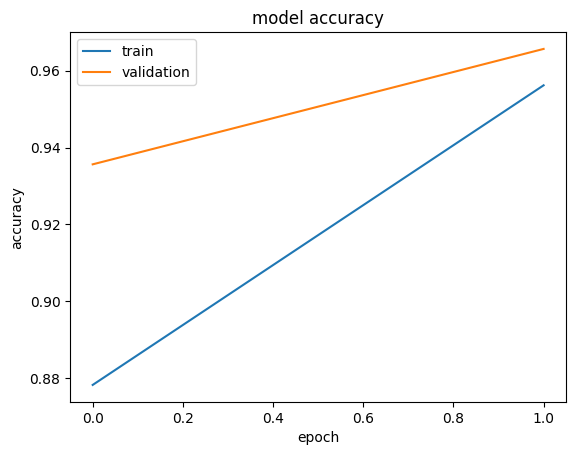

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

In [ ]:
model.save("/kaggle/working/model.h5")